In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
!pip install prophet
!pip install hyperopt

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from hyperopt import hp, fmin, tpe, Trials

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 60)

In [19]:
# 폰트 나눔고딕 설정
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

!apt-get update -qq
!apt-get install fonts-nanum* -qq

import matplotlib.font_manager as fm
import os
import matplotlib.pyplot as plt

!apt-get -qq install fonts-nanum

fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf',
    name='NanumGothic')
fm.fontManager.ttflist.insert(0, fe)
plt.rcParams.update({'font.size': 18, 'font.family': 'NanumGothic'})

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 24 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (11.1 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 121654 files and direc

In [27]:
# 경로 설정
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Prophet/data/temperature.csv', encoding="cp949")

df = df.dropna()

for i in range(len(df)):
  df.loc[i, "date"] = df.loc[i, "최저기온일자"][0:7]

df = df[["date", "평균기온(℃)"]]

df.columns = ["ds", "y"]
df["ds"] = pd.to_datetime(df["ds"])

In [32]:
# 최적화를 위한 하이퍼파라미터 탐색 범위 정의
param_space = {
    'changepoint_prior_scale': hp.uniform('changepoint_prior_scale', 0.001, 0.5),
    'seasonality_prior_scale': hp.uniform('seasonality_prior_scale', 0.01, 10.0),
    'holidays_prior_scale': hp.uniform('holidays_prior_scale', 0.01, 10.0),
    # 다른 하이퍼파라미터들도 필요에 따라 추가 가능
}

def objective(params):
    # Prophet 모델 생성
    m_new = Prophet(changepoint_prior_scale=params['changepoint_prior_scale'],
                    seasonality_prior_scale=params['seasonality_prior_scale'],
                    holidays_prior_scale=params['holidays_prior_scale'],
                    # 다른 하이퍼파라미터들도 필요에 따라 추가
                   )

    m_new.fit(train)
    # 수정(예측할 기간에 따라)
    future_new = m_new.make_future_dataframe(periods = 100)
    forecast_new = m_new.predict(future_new)

    # 예측 결과
    forecast_new[["ds", "yhat"]]
    df_forecast_new = forecast_new[["ds", "yhat"]]

    # 'datetime' 기준으로 merge하여 겹치는 행만 남기기
    merged_df_new = pd.merge(df, df_forecast_new, on='ds', how='inner')

    # 남긴 기간부터 예측한 결과에 대해 MAE 구하기
    target_date = pd.to_datetime(df.loc[len(df)-100, "ds"]) # 수정(예측할 기간에 따라)
    recent_data_new = merged_df_new.loc[merged_df_new['ds'] > target_date]
    mae_new = (abs(recent_data_new["y"] - recent_data_new["yhat"])).mean()

    # 평가 지표를 최소화하는 방향으로 최적화 수행
    return mae_new


# 예측력 계산을 위해 최근 데이터 남겨두기
train = df.iloc[-100:, :] # 수정(예측할 기간에 따라)

trials = Trials()
best = fmin(fn = objective,
            space = param_space,
            algo = tpe.suggest,
            max_evals = 50,  # 원하는 반복 횟수를 설정
            trials = trials)

best_model = Prophet(changepoint_range = 0.8,
                    changepoint_prior_scale = best["changepoint_prior_scale"],
                    seasonality_prior_scale = best["seasonality_prior_scale"])

best_model.fit(train)

future_best = best_model.make_future_dataframe(periods = 100) # 수정(예측할 기간에 따라)
forecast_best = best_model.predict(future_best)

# 예측 결과
forecast_best[["ds", "yhat"]]
df_forecast_best = forecast_best[["ds", "yhat"]]

# 'datetime' 기준으로 merge하여 겹치는 행만 남기기
merged_df_best = pd.merge(train, df_forecast_best, on='ds', how='inner')

# 남긴 기간부터 예측한 결과만 남기기
target_date = pd.to_datetime(df.loc[len(df)-100, "ds"]) # 수정(예측할 기간에 따라)
recent_data_best = merged_df_best.loc[merged_df_best['ds'] > target_date]

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp31muq4d/qen_dfc0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp31muq4d/e8_yixsq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20422', 'data', 'file=/tmp/tmpp31muq4d/qen_dfc0.json', 'init=/tmp/tmpp31muq4d/e8_yixsq.json', 'output', 'file=/tmp/tmpp31muq4d/prophet_modelg95bi6fx/prophet_model-20240107071400.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:14:00 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
07:14:00 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing


  2%|▏         | 1/50 [00:00<00:09,  5.09trial/s, best loss: 0.8720378695576657]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp31muq4d/lepqlw5x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp31muq4d/b7_nbumv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78724', 'data', 'file=/tmp/tmpp31muq4d/lepqlw5x.json', 'init=/tmp/tmpp31muq4d/b7_nbumv.json', 'output', 'file=/tmp/tmpp31muq4d/prophet_modelg0b7stdy/prophet_model-20240107071400.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:14:00 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
07:14:00 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing


  4%|▍         | 2/50 [00:00<00:09,  5.12trial/s, best loss: 0.8720378695576657]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp31muq4d/i2c9qibb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp31muq4d/jddf89n4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64905', 'data', 'file=/tmp/tmpp31muq4d/i2c9qibb.json', 'init=/tmp/tmpp31muq4d/jddf89n4.json', 'output', 'file=/tmp/tmpp31muq4d/prophet_modelkk2f30md/prophet_model-20240107071400.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:14:00 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
07:14:00 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing


  6%|▌         | 3/50 [00:00<00:09,  5.10trial/s, best loss: 0.8720378695576657]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp31muq4d/ibsv2brc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp31muq4d/okqxle31.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92905', 'data', 'file=/tmp/tmpp31muq4d/ibsv2brc.json', 'init=/tmp/tmpp31muq4d/okqxle31.json', 'output', 'file=/tmp/tmpp31muq4d/prophet_modelrk8bzcjz/prophet_model-20240107071401.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:14:01 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
07:14:01 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing


  8%|▊         | 4/50 [00:00<00:09,  4.93trial/s, best loss: 0.871912188307545] 

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp31muq4d/f2yxysqj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp31muq4d/e0df915k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73073', 'data', 'file=/tmp/tmpp31muq4d/f2yxysqj.json', 'init=/tmp/tmpp31muq4d/e0df915k.json', 'output', 'file=/tmp/tmpp31muq4d/prophet_modelyi1lh7fb/prophet_model-20240107071401.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:14:01 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
07:14:01 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing


 10%|█         | 5/50 [00:01<00:09,  4.96trial/s, best loss: 0.8670161101484848]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp31muq4d/mg628vkr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp31muq4d/2y3fiqnh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20005', 'data', 'file=/tmp/tmpp31muq4d/mg628vkr.json', 'init=/tmp/tmpp31muq4d/2y3fiqnh.json', 'output', 'file=/tmp/tmpp31muq4d/prophet_model4sgjni4h/prophet_model-20240107071401.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:14:01 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
07:14:01 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing


 12%|█▏        | 6/50 [00:01<00:08,  4.95trial/s, best loss: 0.8670161101484848]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp31muq4d/hwecleez.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp31muq4d/qdrspgs3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4393', 'data', 'file=/tmp/tmpp31muq4d/hwecleez.json', 'init=/tmp/tmpp31muq4d/qdrspgs3.json', 'output', 'file=/tmp/tmpp31muq4d/prophet_model4es2ynjh/prophet_model-20240107071401.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:14:01 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
07:14:01 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing


 14%|█▍        | 7/50 [00:01<00:08,  5.01trial/s, best loss: 0.8649684423813402]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp31muq4d/m20agqdc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp31muq4d/826hu_wp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78572', 'data', 'file=/tmp/tmpp31muq4d/m20agqdc.json', 'init=/tmp/tmpp31muq4d/826hu_wp.json', 'output', 'file=/tmp/tmpp31muq4d/prophet_modelz415be5f/prophet_model-20240107071401.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:14:01 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
07:14:01 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing


 16%|█▌        | 8/50 [00:01<00:08,  4.93trial/s, best loss: 0.8649684423813402]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp31muq4d/djp7adaq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp31muq4d/lkym669u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40630', 'data', 'file=/tmp/tmpp31muq4d/djp7adaq.json', 'init=/tmp/tmpp31muq4d/lkym669u.json', 'output', 'file=/tmp/tmpp31muq4d/prophet_model8cvx2iuf/prophet_model-20240107071402.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:14:02 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
07:14:02 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing


 18%|█▊        | 9/50 [00:01<00:08,  4.85trial/s, best loss: 0.8649684423813402]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp31muq4d/z_lpp25d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp31muq4d/xuvyubbs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76621', 'data', 'file=/tmp/tmpp31muq4d/z_lpp25d.json', 'init=/tmp/tmpp31muq4d/xuvyubbs.json', 'output', 'file=/tmp/tmpp31muq4d/prophet_model817z7qsr/prophet_model-20240107071402.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:14:02 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
07:14:02 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing


 20%|██        | 10/50 [00:02<00:08,  4.94trial/s, best loss: 0.8649684423813402]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp31muq4d/bm82lm7y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp31muq4d/1irzxyti.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75870', 'data', 'file=/tmp/tmpp31muq4d/bm82lm7y.json', 'init=/tmp/tmpp31muq4d/1irzxyti.json', 'output', 'file=/tmp/tmpp31muq4d/prophet_modelppe0mjtf/prophet_model-20240107071402.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:14:02 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
07:14:02 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing


 22%|██▏       | 11/50 [00:02<00:08,  4.58trial/s, best loss: 0.8649684423813402]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp31muq4d/fzk25nz2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp31muq4d/gobxd6gc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81176', 'data', 'file=/tmp/tmpp31muq4d/fzk25nz2.json', 'init=/tmp/tmpp31muq4d/gobxd6gc.json', 'output', 'file=/tmp/tmpp31muq4d/prophet_model_xoux0nc/prophet_model-20240107071402.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:14:02 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
07:14:02 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing


 24%|██▍       | 12/50 [00:02<00:08,  4.26trial/s, best loss: 0.8649684423813402]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp31muq4d/ysre76j0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp31muq4d/47rk9hku.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83966', 'data', 'file=/tmp/tmpp31muq4d/ysre76j0.json', 'init=/tmp/tmpp31muq4d/47rk9hku.json', 'output', 'file=/tmp/tmpp31muq4d/prophet_modelyfowakfq/prophet_model-20240107071403.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:14:03 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
07:14:03 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing


 26%|██▌       | 13/50 [00:02<00:09,  3.95trial/s, best loss: 0.8649684423813402]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp31muq4d/4_amsx_7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp31muq4d/x34zwvze.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82892', 'data', 'file=/tmp/tmpp31muq4d/4_amsx_7.json', 'init=/tmp/tmpp31muq4d/x34zwvze.json', 'output', 'file=/tmp/tmpp31muq4d/prophet_modelvq5bbbh2/prophet_model-20240107071403.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:14:03 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
07:14:03 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing


 28%|██▊       | 14/50 [00:03<00:09,  3.84trial/s, best loss: 0.8649684423813402]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp31muq4d/7nu9jzt2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp31muq4d/q_z0hqra.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21901', 'data', 'file=/tmp/tmpp31muq4d/7nu9jzt2.json', 'init=/tmp/tmpp31muq4d/q_z0hqra.json', 'output', 'file=/tmp/tmpp31muq4d/prophet_modelyfud3v7u/prophet_model-20240107071403.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:14:03 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
07:14:03 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing


 30%|███       | 15/50 [00:03<00:09,  3.84trial/s, best loss: 0.8649684423813402]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp31muq4d/bnqci0h6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp31muq4d/3fip8j4q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97594', 'data', 'file=/tmp/tmpp31muq4d/bnqci0h6.json', 'init=/tmp/tmpp31muq4d/3fip8j4q.json', 'output', 'file=/tmp/tmpp31muq4d/prophet_model3dy_gebl/prophet_model-20240107071403.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:14:03 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
07:14:03 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing


 32%|███▏      | 16/50 [00:03<00:08,  3.87trial/s, best loss: 0.8649684423813402]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp31muq4d/qayvatus.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp31muq4d/8i1b8_cf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14453', 'data', 'file=/tmp/tmpp31muq4d/qayvatus.json', 'init=/tmp/tmpp31muq4d/8i1b8_cf.json', 'output', 'file=/tmp/tmpp31muq4d/prophet_modelljyje5xx/prophet_model-20240107071404.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:14:04 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
07:14:04 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing


 34%|███▍      | 17/50 [00:03<00:08,  3.80trial/s, best loss: 0.8649684423813402]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp31muq4d/khu5lh_s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp31muq4d/v3xgei7i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44159', 'data', 'file=/tmp/tmpp31muq4d/khu5lh_s.json', 'init=/tmp/tmpp31muq4d/v3xgei7i.json', 'output', 'file=/tmp/tmpp31muq4d/prophet_modeln3lp73z4/prophet_model-20240107071404.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:14:04 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
07:14:04 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing


 36%|███▌      | 18/50 [00:04<00:08,  3.68trial/s, best loss: 0.8649684423813402]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp31muq4d/38zn11kk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp31muq4d/tx_d4a3s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55997', 'data', 'file=/tmp/tmpp31muq4d/38zn11kk.json', 'init=/tmp/tmpp31muq4d/tx_d4a3s.json', 'output', 'file=/tmp/tmpp31muq4d/prophet_modelsfn4wth3/prophet_model-20240107071404.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:14:04 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
07:14:04 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing


 38%|███▊      | 19/50 [00:04<00:08,  3.70trial/s, best loss: 0.8649684423813402]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp31muq4d/bc4sop62.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp31muq4d/q2i1v6e4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44252', 'data', 'file=/tmp/tmpp31muq4d/bc4sop62.json', 'init=/tmp/tmpp31muq4d/q2i1v6e4.json', 'output', 'file=/tmp/tmpp31muq4d/prophet_modelj1u41clu/prophet_model-20240107071404.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:14:04 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
07:14:04 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing


 40%|████      | 20/50 [00:04<00:08,  3.74trial/s, best loss: 0.8649684423813402]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp31muq4d/pi4omph1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp31muq4d/3iwh_7nb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24422', 'data', 'file=/tmp/tmpp31muq4d/pi4omph1.json', 'init=/tmp/tmpp31muq4d/3iwh_7nb.json', 'output', 'file=/tmp/tmpp31muq4d/prophet_modeltz66lmrg/prophet_model-20240107071405.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:14:05 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
07:14:05 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing


 42%|████▏     | 21/50 [00:05<00:08,  3.60trial/s, best loss: 0.8649684423813402]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp31muq4d/9tm60b6s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp31muq4d/shqeqw4v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67866', 'data', 'file=/tmp/tmpp31muq4d/9tm60b6s.json', 'init=/tmp/tmpp31muq4d/shqeqw4v.json', 'output', 'file=/tmp/tmpp31muq4d/prophet_modelwov26zws/prophet_model-20240107071405.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:14:05 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
07:14:05 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing


 44%|████▍     | 22/50 [00:05<00:07,  3.53trial/s, best loss: 0.864321287118501] 

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp31muq4d/q378d1rd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp31muq4d/33uefe_w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50684', 'data', 'file=/tmp/tmpp31muq4d/q378d1rd.json', 'init=/tmp/tmpp31muq4d/33uefe_w.json', 'output', 'file=/tmp/tmpp31muq4d/prophet_modelejpdb5x3/prophet_model-20240107071405.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:14:05 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
07:14:05 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing


 46%|████▌     | 23/50 [00:05<00:07,  3.58trial/s, best loss: 0.864321287118501]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp31muq4d/k0mdw8l1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp31muq4d/8p2evej5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99781', 'data', 'file=/tmp/tmpp31muq4d/k0mdw8l1.json', 'init=/tmp/tmpp31muq4d/8p2evej5.json', 'output', 'file=/tmp/tmpp31muq4d/prophet_modelo_u10qk9/prophet_model-20240107071406.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:14:06 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
07:14:06 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing


 48%|████▊     | 24/50 [00:05<00:07,  3.59trial/s, best loss: 0.864321287118501]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp31muq4d/ml9qa332.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp31muq4d/2ytsi8gk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95967', 'data', 'file=/tmp/tmpp31muq4d/ml9qa332.json', 'init=/tmp/tmpp31muq4d/2ytsi8gk.json', 'output', 'file=/tmp/tmpp31muq4d/prophet_modelo9zicduj/prophet_model-20240107071406.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:14:06 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
07:14:06 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing


 50%|█████     | 25/50 [00:06<00:07,  3.52trial/s, best loss: 0.864321287118501]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp31muq4d/jcelz_q7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp31muq4d/aht2oevx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51849', 'data', 'file=/tmp/tmpp31muq4d/jcelz_q7.json', 'init=/tmp/tmpp31muq4d/aht2oevx.json', 'output', 'file=/tmp/tmpp31muq4d/prophet_modelha4msvg_/prophet_model-20240107071406.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:14:06 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
07:14:06 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing


 52%|█████▏    | 26/50 [00:06<00:06,  3.49trial/s, best loss: 0.864321287118501]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp31muq4d/xsjp3wjq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp31muq4d/_gam2x12.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88529', 'data', 'file=/tmp/tmpp31muq4d/xsjp3wjq.json', 'init=/tmp/tmpp31muq4d/_gam2x12.json', 'output', 'file=/tmp/tmpp31muq4d/prophet_model86lf8el4/prophet_model-20240107071406.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:14:06 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
07:14:07 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing


 54%|█████▍    | 27/50 [00:06<00:06,  3.49trial/s, best loss: 0.864321287118501]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp31muq4d/mvyrq2l0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp31muq4d/5bnxx7yn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61315', 'data', 'file=/tmp/tmpp31muq4d/mvyrq2l0.json', 'init=/tmp/tmpp31muq4d/5bnxx7yn.json', 'output', 'file=/tmp/tmpp31muq4d/prophet_modelx94fkv4d/prophet_model-20240107071407.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:14:07 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
07:14:07 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing


 56%|█████▌    | 28/50 [00:07<00:06,  3.54trial/s, best loss: 0.864321287118501]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp31muq4d/pox5bvsi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp31muq4d/pg_3kv7d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78996', 'data', 'file=/tmp/tmpp31muq4d/pox5bvsi.json', 'init=/tmp/tmpp31muq4d/pg_3kv7d.json', 'output', 'file=/tmp/tmpp31muq4d/prophet_model72fyxekm/prophet_model-20240107071407.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:14:07 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
07:14:07 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing


 58%|█████▊    | 29/50 [00:07<00:05,  3.52trial/s, best loss: 0.864321287118501]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp31muq4d/tbs_c42c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp31muq4d/olgbplvc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99752', 'data', 'file=/tmp/tmpp31muq4d/tbs_c42c.json', 'init=/tmp/tmpp31muq4d/olgbplvc.json', 'output', 'file=/tmp/tmpp31muq4d/prophet_modelglfxp2fz/prophet_model-20240107071407.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:14:07 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
07:14:07 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing


 60%|██████    | 30/50 [00:07<00:05,  3.59trial/s, best loss: 0.864321287118501]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp31muq4d/fghhkqhn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp31muq4d/raj4p2rg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1665', 'data', 'file=/tmp/tmpp31muq4d/fghhkqhn.json', 'init=/tmp/tmpp31muq4d/raj4p2rg.json', 'output', 'file=/tmp/tmpp31muq4d/prophet_modelr0fd5v2m/prophet_model-20240107071408.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:14:08 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
07:14:08 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing


 62%|██████▏   | 31/50 [00:07<00:05,  3.61trial/s, best loss: 0.864321287118501]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp31muq4d/23rr_ocx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp31muq4d/6b41z3yj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73123', 'data', 'file=/tmp/tmpp31muq4d/23rr_ocx.json', 'init=/tmp/tmpp31muq4d/6b41z3yj.json', 'output', 'file=/tmp/tmpp31muq4d/prophet_modelzqbftzoq/prophet_model-20240107071408.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:14:08 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
07:14:08 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing


 64%|██████▍   | 32/50 [00:08<00:05,  3.45trial/s, best loss: 0.864321287118501]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp31muq4d/mpxaumy2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp31muq4d/7qv7h2sg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59795', 'data', 'file=/tmp/tmpp31muq4d/mpxaumy2.json', 'init=/tmp/tmpp31muq4d/7qv7h2sg.json', 'output', 'file=/tmp/tmpp31muq4d/prophet_modelwzxcig6i/prophet_model-20240107071408.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:14:08 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
07:14:08 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing


 66%|██████▌   | 33/50 [00:08<00:05,  3.24trial/s, best loss: 0.8638402008631451]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp31muq4d/lr6hd472.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp31muq4d/4uxsxmcq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42017', 'data', 'file=/tmp/tmpp31muq4d/lr6hd472.json', 'init=/tmp/tmpp31muq4d/4uxsxmcq.json', 'output', 'file=/tmp/tmpp31muq4d/prophet_model2mnr0esj/prophet_model-20240107071409.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:14:09 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
07:14:09 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing


 68%|██████▊   | 34/50 [00:09<00:06,  2.48trial/s, best loss: 0.8638402008631451]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp31muq4d/ovttfjn5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp31muq4d/98w119ot.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93', 'data', 'file=/tmp/tmpp31muq4d/ovttfjn5.json', 'init=/tmp/tmpp31muq4d/98w119ot.json', 'output', 'file=/tmp/tmpp31muq4d/prophet_model6082caib/prophet_model-20240107071409.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:14:09 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
07:14:09 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing


 70%|███████   | 35/50 [00:09<00:05,  2.51trial/s, best loss: 0.8638402008631451]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp31muq4d/fy205hv4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp31muq4d/r4641zbd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47508', 'data', 'file=/tmp/tmpp31muq4d/fy205hv4.json', 'init=/tmp/tmpp31muq4d/r4641zbd.json', 'output', 'file=/tmp/tmpp31muq4d/prophet_models19bhwlq/prophet_model-20240107071410.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:14:10 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
07:14:10 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing


 72%|███████▏  | 36/50 [00:09<00:05,  2.64trial/s, best loss: 0.8638402008631451]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp31muq4d/scncz451.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp31muq4d/d_xhx5_9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55658', 'data', 'file=/tmp/tmpp31muq4d/scncz451.json', 'init=/tmp/tmpp31muq4d/d_xhx5_9.json', 'output', 'file=/tmp/tmpp31muq4d/prophet_modelekmp3rpy/prophet_model-20240107071410.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:14:10 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
07:14:10 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing


 74%|███████▍  | 37/50 [00:10<00:04,  2.87trial/s, best loss: 0.8638402008631451]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp31muq4d/_8k3ysj_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp31muq4d/iupdnzrg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82367', 'data', 'file=/tmp/tmpp31muq4d/_8k3ysj_.json', 'init=/tmp/tmpp31muq4d/iupdnzrg.json', 'output', 'file=/tmp/tmpp31muq4d/prophet_model4lmyreth/prophet_model-20240107071410.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:14:10 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
07:14:10 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing


 76%|███████▌  | 38/50 [00:10<00:03,  3.04trial/s, best loss: 0.8638402008631451]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp31muq4d/w81jup7f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp31muq4d/h1rr8g97.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67034', 'data', 'file=/tmp/tmpp31muq4d/w81jup7f.json', 'init=/tmp/tmpp31muq4d/h1rr8g97.json', 'output', 'file=/tmp/tmpp31muq4d/prophet_modelqs_pdypy/prophet_model-20240107071410.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:14:10 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
07:14:11 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing


 78%|███████▊  | 39/50 [00:10<00:03,  2.95trial/s, best loss: 0.8638402008631451]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp31muq4d/gtlgc8wf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp31muq4d/67yukj0g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30823', 'data', 'file=/tmp/tmpp31muq4d/gtlgc8wf.json', 'init=/tmp/tmpp31muq4d/67yukj0g.json', 'output', 'file=/tmp/tmpp31muq4d/prophet_modelxzburrjj/prophet_model-20240107071411.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:14:11 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
07:14:11 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing


 80%|████████  | 40/50 [00:11<00:03,  2.90trial/s, best loss: 0.8638402008631451]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp31muq4d/t8jv2ar5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp31muq4d/4w8m24u5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45764', 'data', 'file=/tmp/tmpp31muq4d/t8jv2ar5.json', 'init=/tmp/tmpp31muq4d/4w8m24u5.json', 'output', 'file=/tmp/tmpp31muq4d/prophet_model59o03gx1/prophet_model-20240107071411.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:14:11 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
07:14:11 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing


 82%|████████▏ | 41/50 [00:11<00:03,  2.85trial/s, best loss: 0.8638402008631451]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp31muq4d/9oh4o0m7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp31muq4d/ypbv7vc0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74823', 'data', 'file=/tmp/tmpp31muq4d/9oh4o0m7.json', 'init=/tmp/tmpp31muq4d/ypbv7vc0.json', 'output', 'file=/tmp/tmpp31muq4d/prophet_model0ipudt4j/prophet_model-20240107071412.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:14:12 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
07:14:12 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing


 84%|████████▍ | 42/50 [00:11<00:02,  2.89trial/s, best loss: 0.8638402008631451]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp31muq4d/y50b9n3a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp31muq4d/sdtevyx_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32610', 'data', 'file=/tmp/tmpp31muq4d/y50b9n3a.json', 'init=/tmp/tmpp31muq4d/sdtevyx_.json', 'output', 'file=/tmp/tmpp31muq4d/prophet_model5fg_3pj4/prophet_model-20240107071412.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:14:12 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
07:14:12 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing


 86%|████████▌ | 43/50 [00:12<00:02,  2.91trial/s, best loss: 0.8638402008631451]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp31muq4d/akz34ajj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp31muq4d/s95d_2ag.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88573', 'data', 'file=/tmp/tmpp31muq4d/akz34ajj.json', 'init=/tmp/tmpp31muq4d/s95d_2ag.json', 'output', 'file=/tmp/tmpp31muq4d/prophet_modelexqdjfba/prophet_model-20240107071412.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:14:12 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
07:14:12 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing


 88%|████████▊ | 44/50 [00:12<00:01,  3.23trial/s, best loss: 0.8638402008631451]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp31muq4d/t7rdmdlq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp31muq4d/zamz87hi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17799', 'data', 'file=/tmp/tmpp31muq4d/t7rdmdlq.json', 'init=/tmp/tmpp31muq4d/zamz87hi.json', 'output', 'file=/tmp/tmpp31muq4d/prophet_model9yoh3wte/prophet_model-20240107071412.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:14:12 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
07:14:12 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing


 90%|█████████ | 45/50 [00:12<00:01,  3.47trial/s, best loss: 0.8638402008631451]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp31muq4d/oqfkjzpz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp31muq4d/j46kho6t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13504', 'data', 'file=/tmp/tmpp31muq4d/oqfkjzpz.json', 'init=/tmp/tmpp31muq4d/j46kho6t.json', 'output', 'file=/tmp/tmpp31muq4d/prophet_modelaqcw5hxq/prophet_model-20240107071413.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:14:13 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
07:14:13 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing


 92%|█████████▏| 46/50 [00:12<00:01,  3.76trial/s, best loss: 0.8638402008631451]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp31muq4d/rbomo690.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp31muq4d/spmef3mg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19264', 'data', 'file=/tmp/tmpp31muq4d/rbomo690.json', 'init=/tmp/tmpp31muq4d/spmef3mg.json', 'output', 'file=/tmp/tmpp31muq4d/prophet_modelxtl7258x/prophet_model-20240107071413.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:14:13 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
07:14:13 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing


 94%|█████████▍| 47/50 [00:13<00:00,  3.90trial/s, best loss: 0.8638402008631451]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp31muq4d/suintx_a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp31muq4d/rds_0hsw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26021', 'data', 'file=/tmp/tmpp31muq4d/suintx_a.json', 'init=/tmp/tmpp31muq4d/rds_0hsw.json', 'output', 'file=/tmp/tmpp31muq4d/prophet_modelcf3xtknt/prophet_model-20240107071413.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:14:13 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
07:14:13 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing


 96%|█████████▌| 48/50 [00:13<00:00,  4.07trial/s, best loss: 0.8638402008631451]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp31muq4d/3fu8lzcx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp31muq4d/vmkfsq6q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10237', 'data', 'file=/tmp/tmpp31muq4d/3fu8lzcx.json', 'init=/tmp/tmpp31muq4d/vmkfsq6q.json', 'output', 'file=/tmp/tmpp31muq4d/prophet_model8ggmx9q8/prophet_model-20240107071413.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:14:13 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
07:14:13 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing


 98%|█████████▊| 49/50 [00:13<00:00,  4.12trial/s, best loss: 0.8638402008631451]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp31muq4d/6qhgmix3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp31muq4d/2velocha.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97725', 'data', 'file=/tmp/tmpp31muq4d/6qhgmix3.json', 'init=/tmp/tmpp31muq4d/2velocha.json', 'output', 'file=/tmp/tmpp31muq4d/prophet_modeld9zxfez9/prophet_model-20240107071414.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:14:14 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
07:14:14 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing


100%|██████████| 50/50 [00:13<00:00,  3.63trial/s, best loss: 0.8638402008631451]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp31muq4d/obzo25xn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp31muq4d/9a0ybwec.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4810', 'data', 'file=/tmp/tmpp31muq4d/obzo25xn.json', 'init=/tmp/tmpp31muq4d/9a0ybwec.json', 'output', 'file=/tmp/tmpp31muq4d/prophet_modelswdqp_58/prophet_model-20240107071414.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:14:14 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
07:14:14 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing


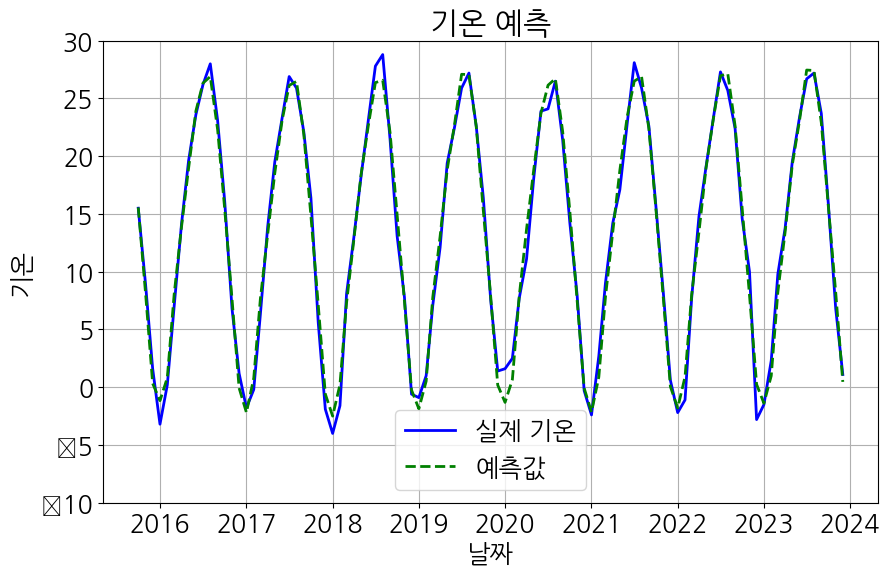

In [33]:
# 시각화
plt.figure(figsize = (10, 6))

plt.rc('font', family='NanumGothic')

plt.plot(recent_data_best["ds"], recent_data_best["y"],
          label = '실제 기온', color='blue',
          linestyle='-', linewidth=2)

plt.plot(recent_data_best["ds"], recent_data_best["yhat"],
          label='예측값', color='green',
          linestyle='--', linewidth=2)

plt.xlabel('날짜')
plt.ylabel('기온')
plt.ylim(-10, 30)
plt.title('기온 예측')
plt.legend()

plt.grid(True)

plt.show()